In [4]:
import numpy as np
import re

import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
from flax.training import train_state


from pathlib import Path


import matplotlib.pyplot as plt

data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [5]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [6]:
data_dict = load_measurements("data/", "w_*.txt")

# 2. Create two basis key groups (regex matched)
amp_keys = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
pha_keys = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]

amp_dict = {k: data_dict[k] for k in amp_keys}
pha_dict = {k: data_dict[k] for k in pha_keys}

amp_loader           = MultiBasisDataLoader(amp_dict, batch_size=128)
pha_loader           = MultiBasisDataLoader(pha_dict, batch_size=128)

In [7]:
from typing import Tuple, Dict, Any
from typing import Optional
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.core import freeze, unfreeze
from jax.nn.initializers import normal, zeros
from collections.abc import Callable, Sequence


class DoubleRBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 1000

    def setup(self):
        self.W_amp = self.param("W_amp", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_amp = self.param("b_amp", nn.initializers.zeros, (self.n_visible,))
        self.c_amp = self.param("c_amp", nn.initializers.zeros, (self.n_hidden,))

        self.W_pha = self.param("W_pha", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param("b_pha", nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param("c_pha", nn.initializers.zeros, (self.n_hidden,))

        self.rotators = {
            'X': jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / jnp.sqrt(2),
            'Y': jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / jnp.sqrt(2),
        }

    def __call__(
            self,
            data_dict: Dict[str, jnp.ndarray],
            aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:

        random_key = aux_vars.get("random_key")

        aux_vars = dict()

        # amplitude training
        comp_basis = 'Z' * self.n_visible
        if len(data_dict) == 1 and comp_basis in data_dict:
            data_batch = data_dict[comp_basis]
            pcd_loss, random_key = self._loss_amp(data_batch, random_key)
            aux_vars["random_key"] = random_key
            return pcd_loss, aux_vars


        # phase training
        all_two_different = all(sum(b != 'Z' for b in basis) == 2 for basis in data_dict)
        if all_two_different:
            phase_loss = self._loss_phase(data_dict)
            return phase_loss, aux_vars

        raise ValueError("Encountered batch of unsupported basis.")


    def _loss_amp(self, data_batch, random_key):
        print("Calculating amplitude loss...")
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        random_key, random_key_bern = jax.random.split(random_key)
        chains = jax.random.bernoulli(random_key_bern, p=0.5, shape=(self.n_chains, self.n_visible)).astype(jnp.float32)
        model_batch, random_key = self._gibbs_sample(W, b, c, chains, random_key, k=self.k)

        model_batch = jax.lax.stop_gradient(model_batch)  # stopping gradient tracking before computing the loss

        # stacking the batches here could maybe yield some performance, not sure though since half the data is gradient detached
        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)
        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)

        return pcd_loss, random_key


    def _loss_phase(self, data_dict: Dict[str, jnp.ndarray]) -> jnp.ndarray:
        print("Calculating phase loss...")

        total_loss = 0.0

        for basis, batch in data_dict.items():  # batch: shape (B, n)
            amps = self.get_rotated_amplitude(batch, basis)  # shape (B,)
            log_probs = jnp.log(jnp.abs(amps) ** 2 + 1e-10)   # shape (B,)
            total_loss -= jnp.mean(log_probs)  # NLL

        return total_loss

    @staticmethod
    def _free_energy(W, b, c, v):
        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    # amplitude RBM specific

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v, key = state

        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_init, rng, k=1, T=1.0):
        body_fun = lambda i, state: DoubleRBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    # phase RBM specific

    def get_amplitude(self, sigma_batch: jnp.ndarray) -> jnp.complex64:
        W_amp = self.variables["params"]["W_amp"]
        b_amp = self.variables["params"]["b_amp"]
        c_amp = self.variables["params"]["c_amp"]

        W_pha = self.variables["params"]["W_pha"]
        b_pha = self.variables["params"]["b_pha"]
        c_pha = self.variables["params"]["c_pha"]

        F_amp = self._free_energy(W_amp, b_amp, c_amp, sigma_batch)
        F_pha = self._free_energy(W_pha, b_pha, c_pha, sigma_batch)

        return jnp.exp(-0.5 * F_amp) * jnp.exp(-0.5j * F_pha)


    def get_rotated_amplitude(self, sigma_b: jnp.ndarray, basis: Sequence[str]) -> jnp.ndarray:
        B, n = sigma_b.shape

        non_z = [i for i, b in enumerate(basis) if b != 'Z']
        if len(non_z) != 2:
            raise ValueError("Only bases with exactly two non-Z entries are supported.")

        j, k = non_z
        Rj = self.rotators[basis[j]]
        Rk = self.rotators[basis[k]]
        U = jnp.kron(Rj, Rk)  # shape (4, 4)

        # 4 local bit combinations to insert at positions j and k
        local_bit_combos = jnp.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]], dtype=sigma_b.dtype)

        # Expand: (B, n) → (4, B, n) with 4 modified versions per sample
        sigma_b_tiled = jnp.repeat(sigma_b[None, :, :], 4, axis=0)  # (4, B, n)
        sigma_b_modified = sigma_b_tiled.at[:, :, [j, k]].set(local_bit_combos[:, None, :])  # (4, B, n)

        # Reshape to (4B, n)
        sigma_b_flat = sigma_b_modified.transpose(1, 0, 2).reshape(4 * B, n)

        # Single call to get_amplitudes
        psis_flat = self.get_amplitude(sigma_b_flat)  # shape (4B,)
        psis = psis_flat.reshape(B, 4)  # shape (B, 4)

        # Compute index into rotated basis
        idx_in = (sigma_b[:, j].astype(int) << 1) | sigma_b[:, k].astype(int)  # shape (B,)

        # Apply U[:, idx_in] ⋅ psis per batch entry
        U_selected = U[:, idx_in]  # shape (4, B)
        amp = jnp.einsum("bi,ib->b", psis, U_selected)  # shape (B,)

        return amp

    @staticmethod
    def _annealing_step(i, state, W, b, c, T_schedule):
        v, rng = state
        T = T_schedule[i]
        v_next, rng_next = DoubleRBM._gibbs_sample(W, b, c, v, rng, k=1, T=T)
        return v_next, rng_next

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:
        W = self.variables["params"]["amp"]["W"]
        b = self.variables["params"]["amp"]["b"]
        c = self.variables["params"]["amp"]["c"]

        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        state = (v, rng)

        body_fun = lambda i, s: DoubleRBM._annealing_step(i, s, W, b, c, T_schedule)
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, state)
        return v_final

In [10]:
import optax
from flax.training.train_state import TrainState
from jax.random import PRNGKey

@jax.jit
def train_step_amp(
        state: TrainState,
        data_batch_dict: Dict[str, jnp.ndarray],
        aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params}, data_batch_dict, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), loss_grads = value_and_grad_fn(state.params)
    new_state = state.apply_gradients(grads=loss_grads)
    return new_state, loss, aux_vars

@jax.jit
def train_step_pha(state: TrainState, data_batch_dict: Dict[str, jnp.ndarray], aux_vars: Dict[str, Any]) -> Tuple[TrainState, jnp.ndarray, Dict[str, Any]]:
    loss_fn = lambda params: state.apply_fn({'params': params}, data_batch_dict, aux_vars)
    (loss, _), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux_vars


def train_rbm_double(
        state_amp: TrainState,
        state_pha: TrainState,
        amp_loader,
        pha_loader,
        num_epochs: int,
        rng: jax.random.PRNGKey,
):
    metrics = {}
    aux_vars = {"random_key": rng}
    amp_iter = iter(amp_loader)

    for epoch in range(num_epochs):
        total_loss_amp = 0.0
        batch_count = 0

        while True:
            try:
                amp_batch_dict = next(amp_iter)
            except StopIteration:
                break

            aux_vars["random_key"], subkey = jax.random.split(aux_vars["random_key"])
            aux_vars_step = dict(aux_vars)
            aux_vars_step["random_key"] = subkey

            state_amp, loss_amp, new_aux = train_step_amp(state_amp, amp_batch_dict, aux_vars_step)

            # Update aux_vars with any new fields
            aux_vars.update(new_aux)

            total_loss_amp += loss_amp
            batch_count += 1

        avg_loss_amp = total_loss_amp / batch_count
        metrics[epoch] = {"amp_loss": float(avg_loss_amp.item())}

        print(f"Epoch [{epoch+1}/{num_epochs}] - Amplitude Loss: {avg_loss_amp:.4f}")

    return state_amp, metrics, aux_vars["random_key"]


In [12]:
# hyperparams
batch_size    = 6400
visible_units = 15
hidden_units  = 30 # larger gives one-hot
k_steps       = 20
lr_amp            = 1e-2
lr_pha            = 1e-2
num_epochs    = 10
pcd_reset     = 64000
chains        = 1000

random_seed = PRNGKey(42)
rng, init_key = jax.random.split(random_seed)

# model initialization
model = DoubleRBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps, n_chains=chains)
dummy_batch_dict = {'Z' * visible_units: jnp.zeros((batch_size, visible_units), dtype=jnp.float32)}
variables = model.init(init_key, dummy_batch_dict, {"random_key": rng})
params = variables["params"]

# define the optimizer and training state
mask_amp = {k: k in {'W_amp', 'b_amp', 'c_amp'} for k in params}
mask_pha = {k: k in {'W_pha', 'b_pha', 'c_pha'} for k in params}
tx_amp = optax.masked(optax.adam(lr_amp), mask_amp)
tx_pha = optax.masked(optax.adam(lr_pha), mask_pha)
state_amp = TrainState.create(apply_fn=model.apply, params=params, tx=tx_amp)
state_pha = TrainState.create(apply_fn=model.apply, params=params, tx=tx_pha)

# start training
state_amp, state_pha, metrics, rng = train_rbm_double(
    state_amp=state_amp,
    state_pha=state_pha,
    amp_loader=amp_loader,
    pha_loader=pha_loader,
    num_epochs=num_epochs,
    rng=rng
)

Calculating amplitude loss...
Calculating amplitude loss...
Epoch [1/10] - Amplitude Loss: -0.4134


ZeroDivisionError: float division by zero

In [216]:
samples = model.apply(
    {"params": state.params},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    rng=rng,
    method=DoubleRBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.0471, 0.1183, 0.0444, 0.0945, 0.0536, 0.0521, 0.0714, 0.0411,
       0.0721, 0.0587, 0.1183, 0.0492, 0.0629, 0.0636, 0.0617],      dtype=float32)

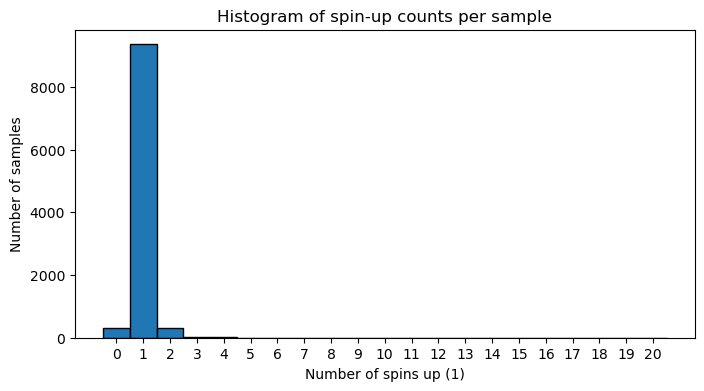

In [217]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [218]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in amp_loader:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.06171875, 0.06703125, 0.0665625 , 0.0659375 , 0.061875  ,
       0.06703125, 0.0646875 , 0.06875   , 0.06921875, 0.060625  ,
       0.07125   , 0.0665625 , 0.07484375, 0.0671875 , 0.06671875],      dtype=float32)

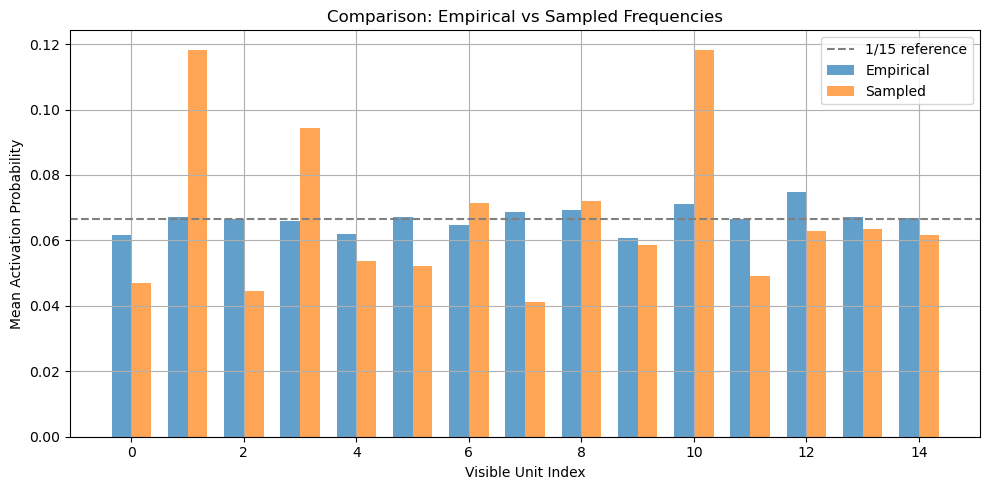

In [219]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()